In [ ]:
import polars as pl
import plotnine as p9

In [92]:
def compare_over_sizes(df: pl.DataFrame, label_all_sizes: bool = True):

    plot = (
        p9.ggplot(
            df,
            p9.aes(x="size", y="mean", group="function", color="function"),
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.geom_errorbar(p9.aes(ymin="min", ymax="max"))
        + p9.ylab("Mean (Min, Max) Seconds")
        + p9.theme_538()
    )

    if label_all_sizes:
        sizes = df["size"].unique().sort()
        plot = plot + p9.scale_x_continuous(breaks=sizes)

    return plot

In [93]:
df = pl.scan_parquet("results/results.parquet").collect()

# Correlation

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


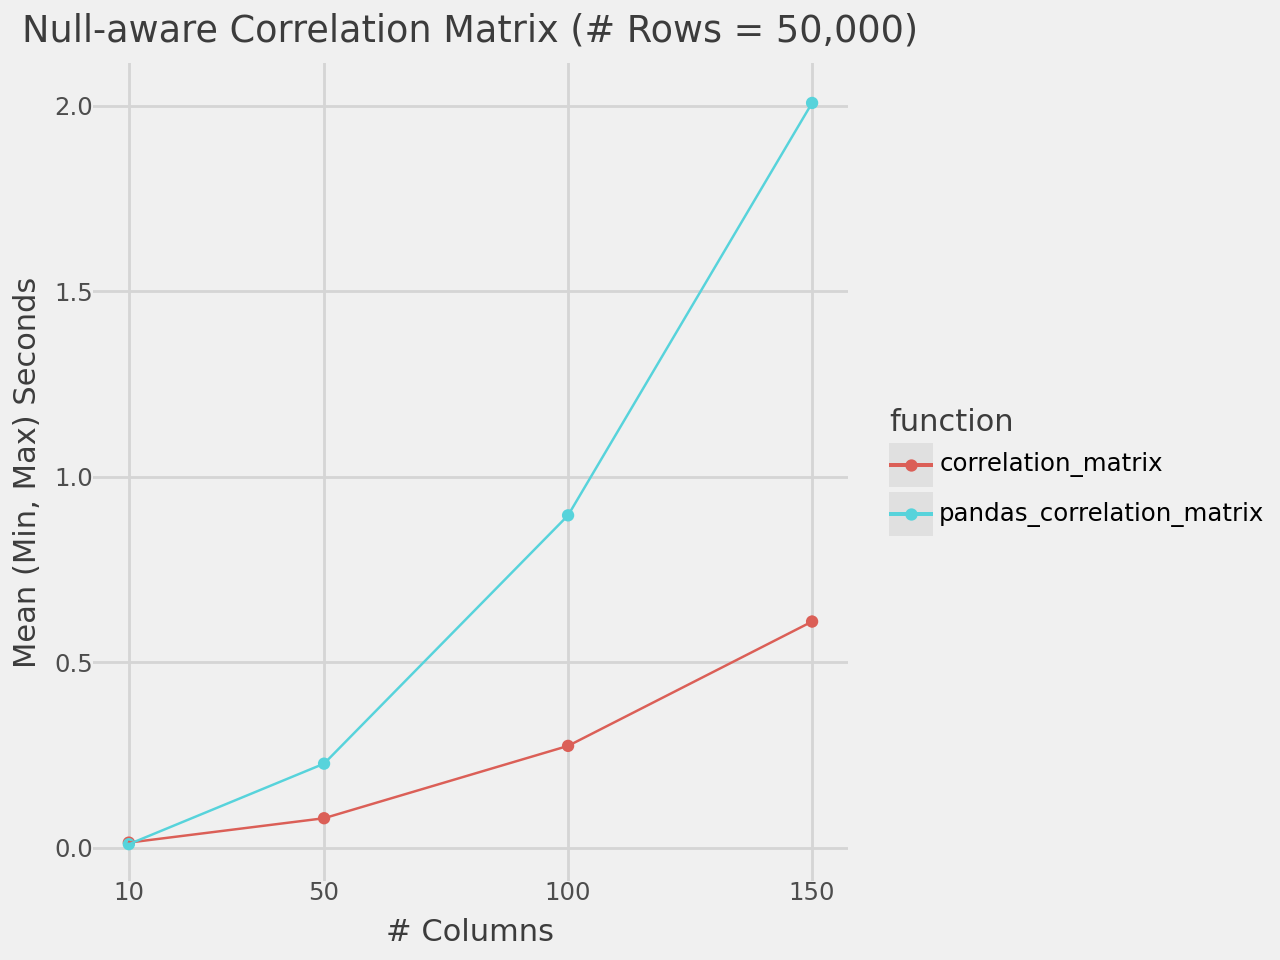

In [94]:
tmp = (
    df.filter(pl.col("group").eq("correlation_matrix"))
    .with_columns(pl.col("parameters").str.json_decode())
    .unnest("parameters")
    .with_columns(pl.col("n_rows").max().alias("_max_rows"))
)

(
    compare_over_sizes(
        tmp.filter(pl.col("n_rows").eq(pl.col("_max_rows"))).rename({"n_cols": "size"})
    )
    + p9.labs(x="# Columns")
    + p9.ggtitle(
        f"Null-aware Correlation Matrix (# Rows = {tmp["_max_rows"].item(0):,})"
    )
)

# Metrics

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


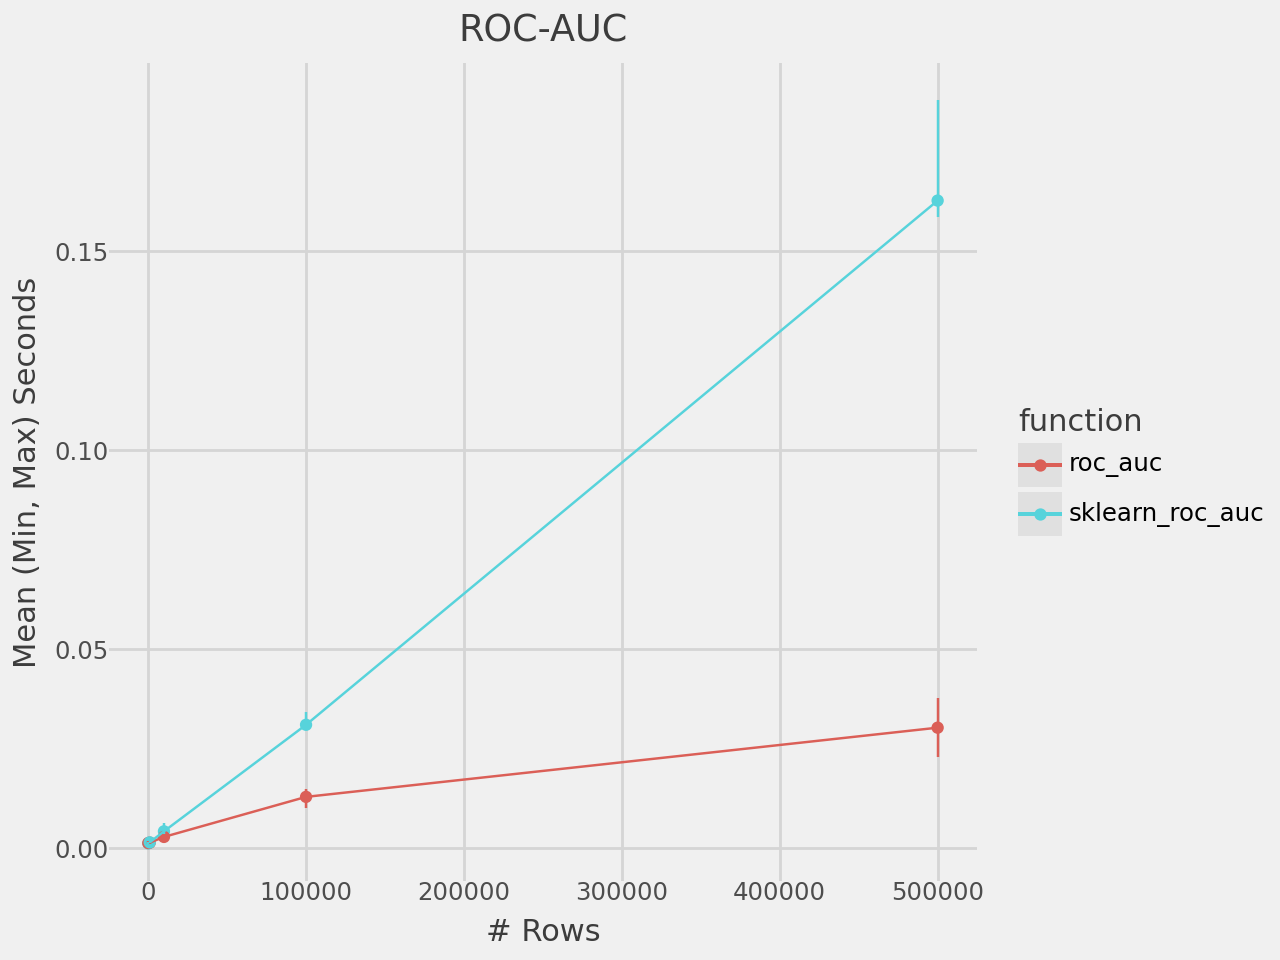

In [95]:
(
    compare_over_sizes(
        df.filter(pl.col("group").eq("roc_auc"))
        .with_columns(pl.col("parameters").str.json_decode())
        .unnest("parameters")
        .rename({"n": "size"}),
        label_all_sizes=False,
    )
    + p9.labs(x="# Rows")
    + p9.ggtitle("ROC-AUC")
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


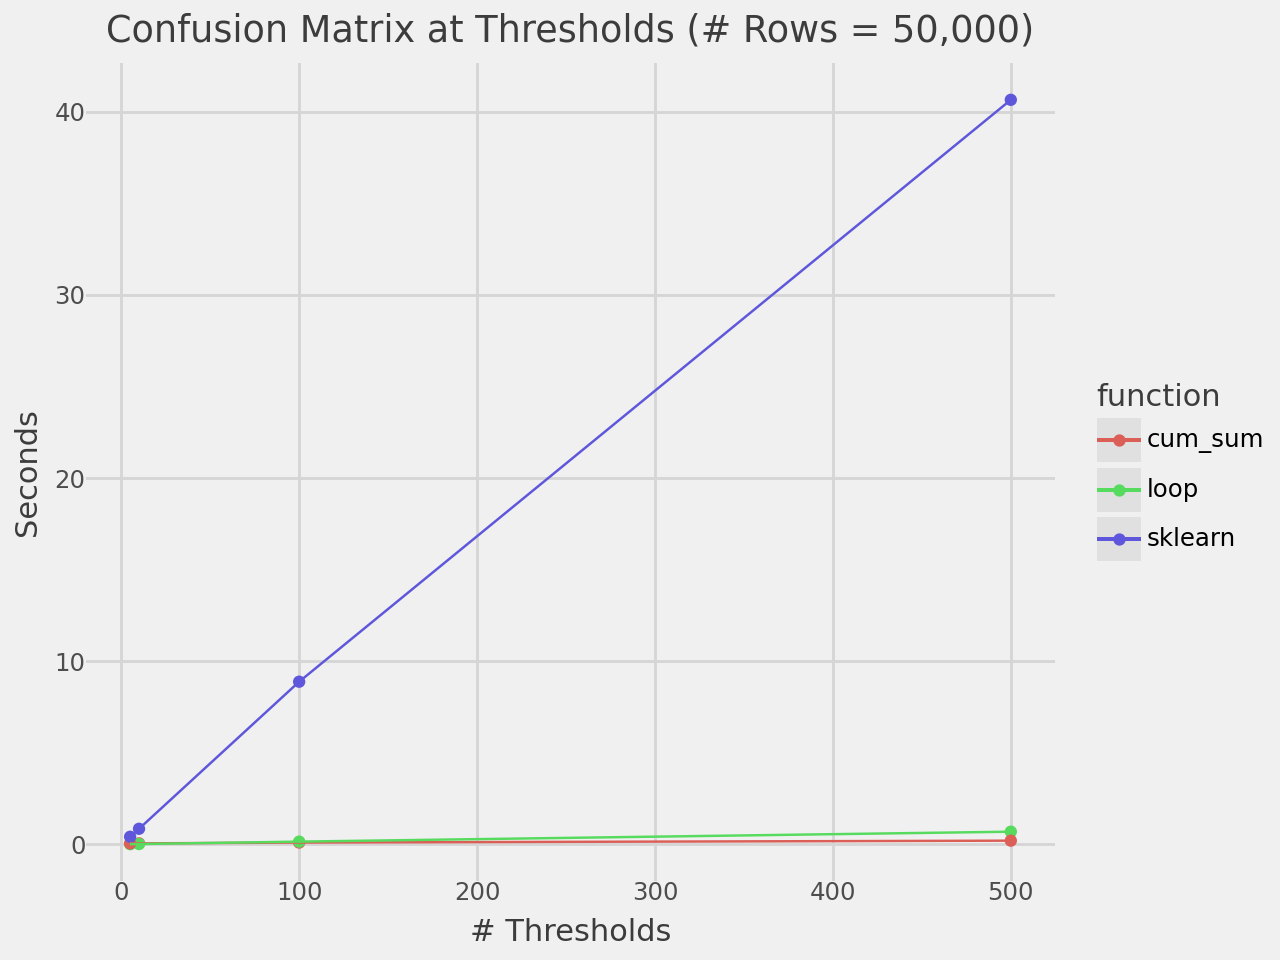

In [96]:
tmp = (
    df.filter(pl.col("group").eq("confusion_matrix_at_thresholds"))
    .with_columns(pl.col("parameters").str.json_decode())
    .unnest("parameters")
    .with_columns(
        pl.when(pl.col("strategy").is_not_null())
        .then(pl.format("{}{}", pl.col("function"), pl.col("strategy")))
        .otherwise(pl.col("function"))
        .str.replace_all("confusion_matrix_at_thresholds", "")
        .str.strip_chars_end("_")
        .alias("function"),
        pl.col("n").max().alias("_max_n"),
        # pl.col("mean", "min", "max").log1p(),
    )
)

(
    compare_over_sizes(
        tmp.filter(pl.col("n").eq(pl.col("_max_n"))).rename({"n_thresholds": "size"}),
        label_all_sizes=False,
    )
    + p9.labs(x="# Thresholds", y="Seconds")
    + p9.ggtitle(f"Confusion Matrix at Thresholds (# Rows = {tmp["_max_n"].item(0):,})")
)

# Bootstrap

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


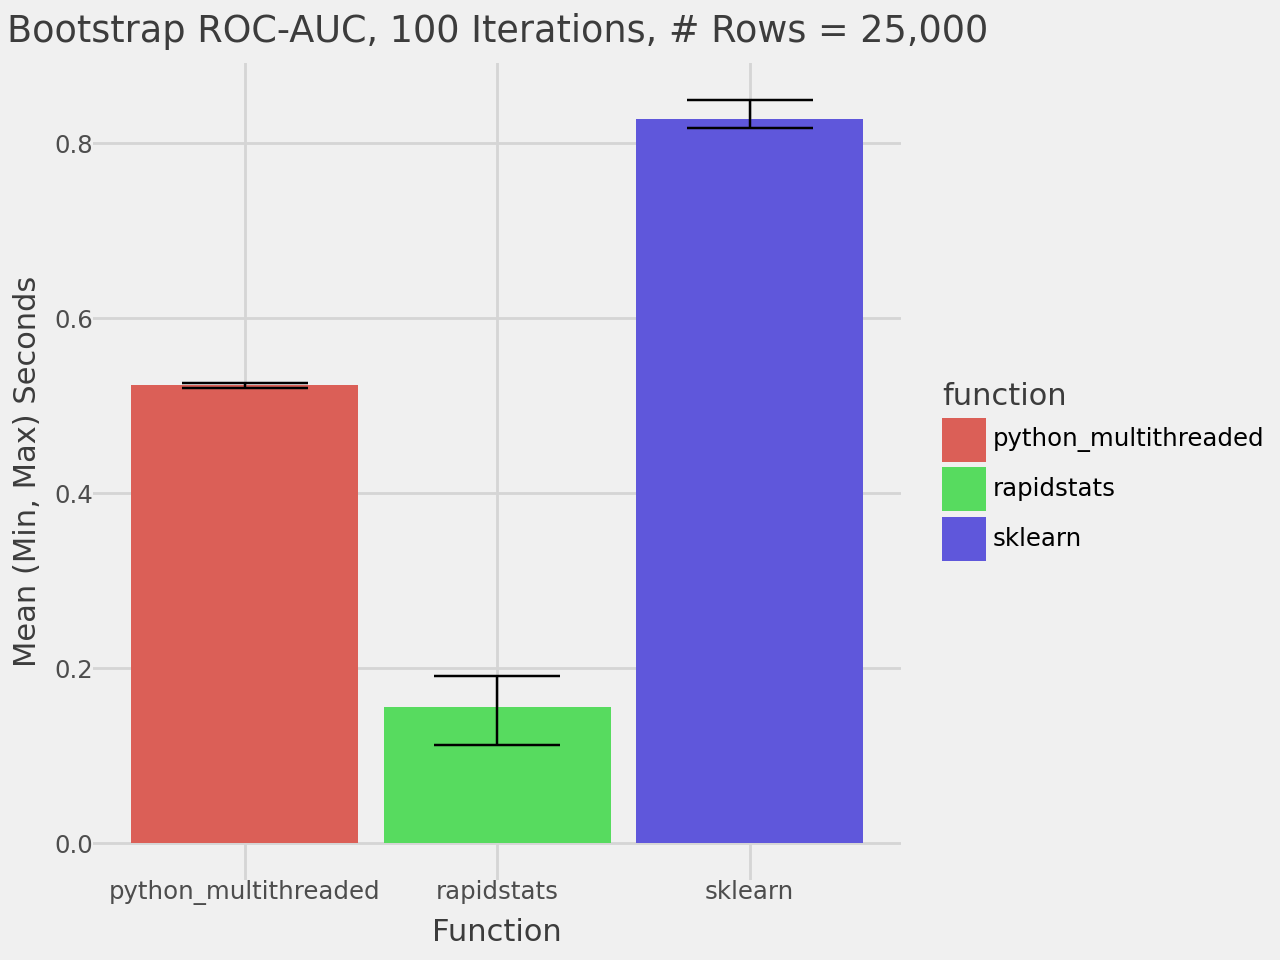

In [102]:
(
    p9.ggplot(
        df.filter(pl.col("group").eq("bootstrap_roc_auc")).with_columns(
            pl.col("function")
            .str.replace_all("bootstrap_roc_auc", "")
            .str.strip_suffix("_")
            .replace({"": "rapidstats"})
        ),
        p9.aes(x="function", y="mean"),
    )
    + p9.geom_col(p9.aes(fill="function"))
    + p9.geom_errorbar(p9.aes(ymin="min", ymax="max"))
    + p9.labs(x="Function", y="Mean (Min, Max) Seconds")
    + p9.ggtitle("Bootstrap ROC-AUC, 100 Iterations, # Rows = 25,000")
    + p9.theme_538()
)